# Chapter 6 - Linear Model Selection and Regularization

- [1. Model Selection Methods](#1.-Model-Selection-Methods)
- [2. Ridge Regression](#2.-Ridge-Regression)
- [3. The Lasso](#3.-The-Lasso)
- [4. Principal Components Regression](#4.-Principal-Components-Regression)
- [5. Partial Least Squares](#5.-Partial-Least-Squares)

In [261]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import itertools
import time
import statsmodels.api as sm
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-white')


## 1. Model Selection Methods 

Reference link : https://xavierbourretsicotte.github.io/subset_selection.html#Comparing-models:-AIC,-BIC,-Mallows'CP

### 1.1. Load dataset
The credit dataset is a use case for linear regression where some predictors are qualitative.

In [262]:
credit = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
credit.head(3)

Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   

   Ethnicity  Balance  
0  Caucasian      333  
1      Asian      903  
2      Asian      580

### 1.2. Encoding qualitative data

In [263]:
credit = pd.get_dummies(credit, columns = ['Gender', 'Student','Married','Ethnicity'],drop_first = True)
credit.head(3)

Income  Limit  Rating  Cards  Age  Education  Balance  Gender_Female  \
0   14.891   3606     283      2   34         11      333              0   
1  106.025   6645     483      3   82         15      903              1   
2  104.593   7075     514      4   71         11      580              0   

   Student_Yes  Married_Yes  Ethnicity_Asian  Ethnicity_Caucasian  
0            0            1                0                    1  
1            1            1                1                    0  
2            0            0                1                    0

<a id='subset'></a>
### 1.3. Best Subset Selection
To perform best selection, we fit separate models for each possible combination of the n predictors and then select the best subset. That is we fit:

- All models that contains exactly one predictor
- All models that contain 2 predictors at the second step
- All models that contain 3 predictors at the thrid step
- ...
- Until reaching the end point where all n predictors are included in the model

This results in 2n possibilities as this is a power set problem. In our case there are 2^11=2048 possible combinations

### 1.4. Helper function for fitting linear regression (Sklearn)

In [264]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

### 1.5. Implementing Best subset selection (using itertools.combinations)

In [265]:
#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
# tqdm.tnrange : progress bar
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})
df.head()

numb_features           RSS  R_squared   features
0              1  6.620874e+07   0.214977  (Income,)
1              1  2.171566e+07   0.742522   (Limit,)
2              1  2.143512e+07   0.745848  (Rating,)
3              1  8.370950e+07   0.007475   (Cards,)
4              1  8.433963e+07   0.000003     (Age,)

### 1.6. Finding the best subsets for each number of features
Using the smallest RSS value, or the largest R_squared value



https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [266]:
print(pd.DataFrame({'name':['a','b','a','b'], 'height':[100,200,300,400]}).groupby('name').mean())

      height
name        
a        200
b        300


In [267]:
print(pd.DataFrame({'name':['a','b','a','b'], 'height':[100,200,300,400]}).groupby('name').transform('sum'))

   height
0     400
1     600
2     400
3     600


In [268]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))

numb_features           RSS  R_squared                       features
2               1  2.143512e+07   0.745848                      (Rating,)
12              2  1.053254e+07   0.875118               (Income, Rating)
79              3  4.227219e+06   0.949879  (Income, Rating, Student_Yes)

numb_features           RSS  R_squared                       features
2               1  2.143512e+07   0.745848                      (Rating,)
12              2  1.053254e+07   0.875118               (Income, Rating)
79              3  4.227219e+06   0.949879  (Income, Rating, Student_Yes)

### 1.7. Adding columns to the dataframe with RSS and R squared values of the best subset

In [269]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

numb_features           RSS  R_squared   features       min_RSS  \
0              1  6.620874e+07   0.214977  (Income,)  2.143512e+07   
1              1  2.171566e+07   0.742522   (Limit,)  2.143512e+07   
2              1  2.143512e+07   0.745848  (Rating,)  2.143512e+07   
3              1  8.370950e+07   0.007475   (Cards,)  2.143512e+07   
4              1  8.433963e+07   0.000003     (Age,)  2.143512e+07   

   max_R_squared  
0       0.745848  
1       0.745848  
2       0.745848  
3       0.745848  
4       0.745848

### 1.8. Plotting the best subset selection process

In [270]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

<a id='forward'></a>
### 1.9. Forward stepwise selection
For computational reasons, the best subset cannot be applied for any large n due to the 2^n complexity. 

Forward Stepwise begins with a model containing no predictors, and then adds predictors to the model, one at the time. 

At each step, the variable that gives the greatest additional improvement to the fit is added to the model.

### Algorithm
Let M0 denote the null model which contains no predictors

- For k=1,2,...,n−1
    - Consider all n−k models that augment the predictors in Mk with one additional predictor
    - Choose the 'best' among these n−k models, and call it Mk+1
- Select the single best model among M0,M1,...,Mn using cross validated predicton error, Cp, BIC, adjusted R2 or any other method.

In [271]:
#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

### 1.10. Displaying results of the first 4 steps

In [272]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Rating'], 21435122.0),
 (2, ['Rating', 'Income'], 10532541.0),
 (3, ['Rating', 'Income', 'Student_Yes'], 4227219.0),
 (4, ['Rating', 'Income', 'Student_Yes', 'Limit'], 4032502.0)]

### 1.11. Exercise - Backward stepwise selection
For computational reasons, the best subset cannot be applied for any large n due to the 2^n complexity.
Backward Stepwise begins with a model containing all predictors, and then removes predictors to the model, one at the time.
At each step, the variable that gives the smallest additional improvement to the fit is removed from the model.

1. Implement Backward stepwise selection (Refer to Section 1.9.)
2. Display the results of the first 4 steps (Refer to Section 1.10.)

In [273]:
# Implement Backward stepwise selection (Refer to Section 1.9.)
Y2 = credit.Balance
X2 = credit.drop(columns = 'Balance', axis = 1)
k2 = 11

remaining_features2 = list(X.columns.values)
features2 = []
RSS_list2, R_squared_list2 = [], [] #Due to 1 indexing of the loop...
features_list2 = []
numb_features2 = []

for i in range(1,k):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features2,1):
            RSS = fit_linear_reg(X[list(set(remaining_features2) - set(combo))],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    remaining_features2.remove(best_feature)
    
    #Saving values for plotting
    RSS_list2.append(best_RSS)
    R_squared_list2.append(best_R_squared)
    features_list2.append(set(remaining_features2))
    numb_features2.append(len(remaining_features2))   

In [274]:
# Display the results of the first 4 steps (Refer to Section 1.10.)
print('Backward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(k - i,features_list2[i], round(RSS_list2[i])) for i in range(1,5)])

Backward stepwise subset selection
Number of features | Features | RSS


[(10,
  {'Age',
   'Cards',
   'Ethnicity_Asian',
   'Gender_Female',
   'Income',
   'Limit',
   'Married_Yes',
   'Rating',
   'Student_Yes'},
  3798367.0),
 (9,
  {'Age',
   'Cards',
   'Ethnicity_Asian',
   'Gender_Female',
   'Income',
   'Limit',
   'Rating',
   'Student_Yes'},
  3804746.0),
 (8,
  {'Age',
   'Cards',
   'Gender_Female',
   'Income',
   'Limit',
   'Rating',
   'Student_Yes'},
  3810759.0),
 (7, {'Age', 'Cards', 'Income', 'Limit', 'Rating', 'Student_Yes'}, 3821620.0)]

<a id='compare'></a>
## 2. Comparing models: AIC, BIC, Mallows'CP
The training set Mean Squared Error (MSE) is generally an underestimate of the test MSE. This is because when we fit a model to the training data using least squares, we specifically estimate the regression coefficients such that the training RSS is minimized. In particular, the training RSS decreases as we add more features to the model, but the test error may not. Therefore the training RSS and $R^2$ may not be used for selecting the best model unless we adjust for this underestimation. 

###  Theoretical justification
$C_p$, AIC, BIC all have rigorous theoretical justification that rely on asymptotic arguments, i.e. when the sample size $m$ grows very large, whereas the adjusted $R^2$, although quite intuitive, is not as well motivated in statistical theory. 

### Combining forward stepwise results into a new DataFrame

In [275]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

### 2.1. Computing the C_p, AIC, BIC and R-square adjusted
### Estimation of $\hat\sigma^2$
Using the RSS of the full model with $p$ features, (i.e.the smallest RSS) we estimate $\hat\sigma^2$ as: $$ \hat\sigma^2 = \frac{RSS}{m - p -1} $$

In [276]:
# sample number
m = len(Y)
# predictor number
p = 11
hat_sigma_squared = min(df1['RSS']) / (m - p -1)

### Mallow's $C_p$
Mallow's $C_p$ is named after Colin Lingwood Mallows and is defined as: $$ C_p = \frac{1}{m} (RSS + 2d\hat\sigma^2)$$ where $\hat\sigma^2$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement. Typically $\hat\sigma^2$ is estimated using the full model containing all predictors. Essentially,the $C_p$ statistic adds a penalty of $2d\hat\sigma^2$ to the training RSS in order to adjust for the fact that the training error tends to underestimate the test error. Clearly, the penalty increases as the number of predictors in the model increases, and this is intended to adjust for the corresponding decrease in training RSS. It can be shown that if $\hat\sigma^2$ is an unbiased estimate of $\sigma^2$ then $C_p$ is an unbiased estimate of the test MSE, so we choose the model with the smallest $C_p$. 

In [277]:
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )

### Akaike's Information Criteria (AIC)
The AIC criterion is defiend for a large class of models fit by maximum likelihood. In the case of a linear model with Gaussian errors, MLE and least squares are the same thing and the AIC is given by $$ AIC = \frac{1}{m\hat \sigma^2} (RSS + 2d\hat\sigma^2)$$ 

In [278]:
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )

### 2.2 Exercise 

Calculate BIC & Adjusted $R^2$ to dataframe

### Bayesian Information Criteria (BIC)
BIC is derived from a Bayesian point of view, and looks similar to the $C_p$ and $AIC$ - it is defined (up to irrelevant constants) as: $$ BIC = \frac{1}{m\hat \sigma^2} (RSS + \log(m) d \hat\sigma^2)$$ Like $C_p$ and AIC, the BIC will tend to take small values for a model with low test error. 

In [279]:
# Calculate BIC as df1['BIC']
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )

### Adjusted $R^2$
Since the $R^2$ always increases as more variables are added, the adjusted $R^2$ accounts for that fact and introduces a penalty. The intuition is that once all the correct variables have been included in the model,additional _noise_ variables will lead to a very small decrase in RSS, but an increase in $k$ and hence will decrease the adjusted $R^2$. In effect, we pay a price for the inclusion of unnecessary variables in the model. $$ R_{a}^2 = 1 - \frac{RSS / (m - k -1)}{TSS / (m - 1)} = 1 - (1 - R^2) \frac{m - 1}{m - k - 1} $$ 

In [280]:
# Calculate Adjusted R^2 as df1['R_squared_adj']
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))

In [281]:
df1

features           RSS  \
1                                            [Rating]  2.143512e+07   
2                                    [Rating, Income]  1.053254e+07   
3                       [Rating, Income, Student_Yes]  4.227219e+06   
4                [Rating, Income, Student_Yes, Limit]  4.032502e+06   
5         [Rating, Income, Student_Yes, Limit, Cards]  3.866091e+06   
6    [Rating, Income, Student_Yes, Limit, Cards, Age]  3.821620e+06   
7   [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.810759e+06   
8   [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.804746e+06   
9   [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.798367e+06   
10  [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.791345e+06   
11  [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.786730e+06   

    R_squared  numb_features           C_p       AIC       BIC  R_squared_adj  
1    0.745848              1  53636.603151  5.495771  5.505750       0.745210  
2    0.875118              2  26428.949364  2.707991  2.727949       0.874489  
3    0.949879              3  10714.442485  1.097835  1.127771       0.949499  
4    0.952188              4  10276.446437  1.052956  1.092871       0.951703  
5    0.954161              5   9909.218362  1.015329  1.065222       0.953579  
6    0.954688              6   9846.837591  1.008937  1.068809       0.953996  
7    0.954817              7   9868.483418  1.011155  1.081006       0.954010  
8    0.954888              8   9902.248962  1.014615  1.094444       0.953965  
9    0.954964              9   9935.100415  1.017981  1.107789       0.953924  
10   0.955047             10   9966.344067  1.021182  1.120969       0.953891  
11   0.955102             11  10003.604241  1.025000  1.134765       0.953829

### 2.3. Find a best model based on a Adjusted $R^2$ 

In [282]:
print(df1['R_squared_adj'].idxmax())
print(df1['R_squared_adj'].max())

7
0.9540098163629882


### 2.4. Plotting the computed values as a function of number of features

In [283]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Forward stepwise selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

###  2.5. Exercise

1. Calculate C_p, AIC, BIC and R-square adjusted of Backward stepwise selection result (from Section 1.11.)
2. Find a best model based on one metric
3. Plot the computed values (refer to Section 2.4.)

In [284]:
# Calculate C_p, AIC, BIC and R-square adjusted of Backward stepwise selection result (from Section 1.11.)

#Store in DataFrame
df2 = pd.DataFrame({'numb_features': numb_features2,'RSS': RSS_list2, 'R_squared':R_squared_list2,'features':features_list2})
df2.head()

hat_sigma_squared2 = min(df2['RSS']) / (m - p -1)

df2['R_squared_adj'] = 1 - ( (1 - df2['R_squared'])*(m-1)/(m-df2['numb_features'] -1))
df2['BIC'] = (1/(m*hat_sigma_squared)) * (df2['RSS'] +  np.log(m) * df2['numb_features'] * hat_sigma_squared2 )
df2['AIC'] = (1/(m*hat_sigma_squared)) * (df2['RSS'] + 2 * df2['numb_features'] * hat_sigma_squared2 )
df2['C_p'] = (1/m) * (df2['RSS'] + 2 * df2['numb_features'] * hat_sigma_squared2 )
df2.head()

numb_features           RSS  R_squared  \
0             10  3.791345e+06   0.955047   
1              9  3.798367e+06   0.954964   
2              8  3.804746e+06   0.954888   
3              7  3.810759e+06   0.954817   
4              6  3.821620e+06   0.954688   

                                            features  R_squared_adj       BIC  \
0  {Ethnicity_Asian, Student_Yes, Married_Yes, Li...       0.953891  1.121151   
1  {Ethnicity_Asian, Student_Yes, Married_Yes, Li...       0.953924  1.107953   
2  {Ethnicity_Asian, Student_Yes, Limit, Income, ...       0.953965  1.094590   
3  {Student_Yes, Limit, Income, Rating, Age, Card...       0.954010  1.081134   
4   {Student_Yes, Limit, Income, Rating, Age, Cards}       0.953996  1.068919   

        AIC          C_p  
0  1.021243  9966.938804  
1  1.018036  9935.635678  
2  1.014664  9902.724751  
3  1.011198  9868.899734  
4  1.008974  9847.194433

In [285]:
# Find a best model based on one metric
print(df2['R_squared_adj'].idxmax())
print(df2['R_squared_adj'].max())

3
0.9540098163629882


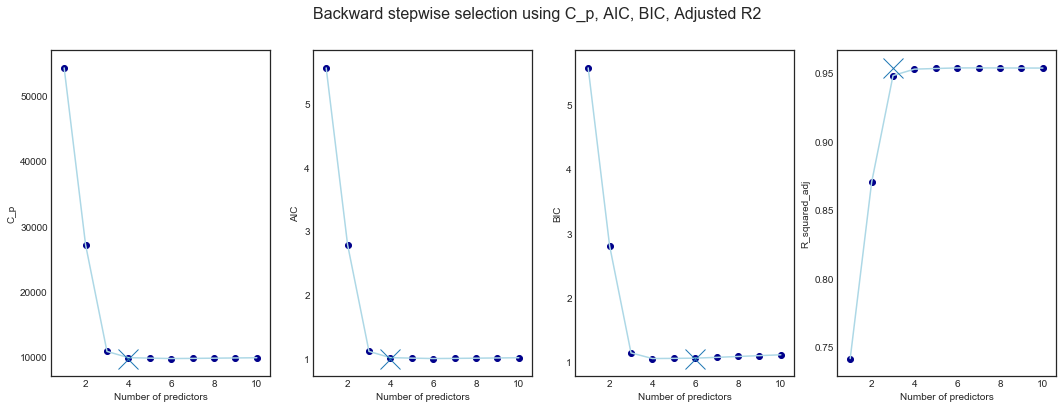

In [338]:
# Plot the computed values (refer to Section 2.4.)
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df2['numb_features'],df2[v], color = 'lightblue')
    ax.scatter(df2['numb_features'],df2[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df2[v].idxmax(),df2[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df2[v].idxmin(),df2[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Backward stepwise selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

## 3. Ridge Regression

### 3.1. Load dataset

In [287]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [288]:
df.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
Player                                                                          
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  \
Player                                                                    
-Alan Ashby            69    321   414     375      N        W      632   
-Alvin Davis           63    224   266     263      A        W      880   
-Andre Dawson         225    828   838     354      N        E      200   
-Andres Galarraga      12     48    46      33      N        E      805   
-Alfredo Griffin       19    501   336     194      A        W      282   

                   Assists  Errors  Salary NewLeague  
Player                                                
-Alan Ashby             43      10   475.0         N  
-Alvin Davis            82      14   480.0         A  
-Andre Dawson           11       3   500.0         N  
-Andres Galarraga       40       4    91.5         N  
-Alfredo Griffin       421      25   750.0         A

In [289]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0           1            1   

                   NewLeague_N  
Player                          
-Alan Ashby             

In [290]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [291]:
X.head(5)

AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat  \
Player                                                                     
-Alan Ashby        315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0   
-Alvin Davis       479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0   
-Andre Dawson      496.0  141.0   20.0  65.0  78.0   37.0   11.0  5628.0   
-Andres Galarraga  321.0   87.0   10.0  39.0  42.0   30.0    2.0   396.0   
-Alfredo Griffin   594.0  169.0    4.0  74.0  51.0   35.0   11.0  4408.0   

                    CHits  CHmRun  CRuns   CRBI  CWalks  PutOuts  Assists  \
Player                                                                      
-Alan Ashby         835.0    69.0  321.0  414.0   375.0    632.0     43.0   
-Alvin Davis        457.0    63.0  224.0  266.0   263.0    880.0     82.0   
-Andre Dawson      1575.0   225.0  828.0  838.0   354.0    200.0     11.0   
-Andres Galarraga   101.0    12.0   48.0   46.0    33.0    805.0     40.0   
-Alfredo Griffin   1133.0    19.0  501.0  336.0   194.0    282.0    421.0   

                   Errors  League_N  Division_W  NewLeague_N  
Player                                                        
-Alan Ashby          10.0         1           1            1  
-Alvin Davis         14.0         0           1            0  
-Andre Dawson         3.0         1           0            1  
-Andres Galarraga     4.0         1           0            1  
-Alfredo Griffin     25.0         0           1            0

#### I executed the R code and downloaded the exact same training/test sets used in the book.

In [292]:
X_train = pd.read_csv('Data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

### 3.2. Ridge Regression in scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

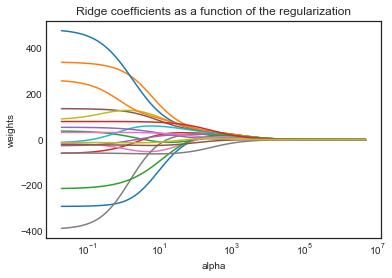

In [293]:
alphas = 5**np.linspace(10,-2,100)*0.5 

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### 3.2.1. Alpha = 4

In [294]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [295]:
ridge2 = Ridge(alpha=4)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

97383.68965102118

In [296]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat         -161.784058
Hits           118.911404
HmRun           52.645719
Runs           -43.295947
RBI             37.339573
Walks          138.214992
Years         -106.916784
CAtBat         -21.080864
CHits          115.933862
CHmRun         -17.949420
CRuns          239.723217
CRBI           -17.945273
CWalks         -59.754770
PutOuts         21.752383
Assists        -68.676906
Errors          89.610291
League_N        31.048268
Division_W     -13.553466
NewLeague_N      4.350305
dtype: float64

#### 3.2.2. Alpha = $10^{10}$  (Alpha graph & find optimal alpha)
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [297]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

193253.09741651407

In [298]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          2.291553e-06
Hits           2.428111e-06
HmRun          2.051677e-06
Runs           2.372252e-06
RBI            2.538921e-06
Walks          2.974270e-06
Years          1.572334e-06
CAtBat         2.507043e-06
CHits          2.666936e-06
CHmRun         2.280416e-06
CRuns          2.839982e-06
CRBI           2.526355e-06
CWalks         2.544939e-06
PutOuts        4.880225e-07
Assists       -1.149268e-06
Errors         2.067779e-06
League_N       5.324293e-07
Division_W     5.051366e-07
NewLeague_N    5.291999e-07
dtype: float64

#### 3.2.3. Training mse with different alpha value

Text(0.5, 1.0, 'Training mse with different alpha')

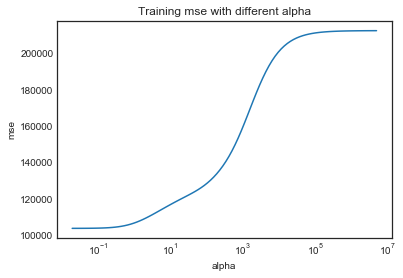

In [299]:
alphas = 5**np.linspace(10,-2,100)*0.5 

mse = []

for a in alphas:
    ridge2 = Ridge(alpha=a)
    ridge2.fit(scaler.transform(X_train), y_train)
    pred = ridge2.predict(scaler.transform(X_train))
    mse.append(mean_squared_error(y_train, pred))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha')

#### 3.2.4. Training mse with different alpha value (Cross validation)

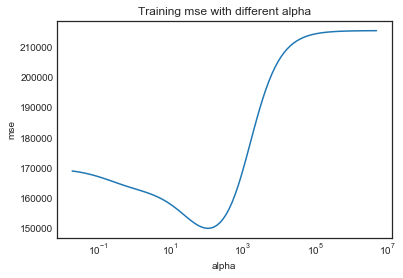

In [300]:
alphas = 5**np.linspace(10,-2,100)*0.5 
mse = []

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

for a in alphas:
    ridge2 = Ridge(alpha=a)
    mse.append(-1*cross_val_score(ridge2, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean())

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

#### 3.2.5. Test mse with different alpha value

In [301]:
alphas = 5**np.linspace(10,-2,100)*0.5 


mse = []

for a in alphas:
    ridge2 = Ridge(alpha=a)
    ridge2.fit(scaler.transform(X_train), y_train)
    pred = ridge2.predict(scaler.transform(X_test))
    mse.append(mean_squared_error(y_test, pred))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Test mse with different alpha')

Text(0.5, 1.0, 'Test mse with different alpha')

#### 3.2.6. Compute the regularization path using RidgeCV
Ridge regression with built-in cross-validation.

Default cross validation method is "Generalized Cross-Validation" (efficient Leave-One-Out).

In [302]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([4.88281e+06, 4.01741e+06, ..., 2.43082e-02, 2.00000e-02]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [303]:
# Optimal alpha that RidgeCV found
ridgecv.alpha_

106.87349666729351

In [304]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))
# Compare this mse value with an above graph (MSE with different alpha)

97171.9003652917

In [305]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           6.527403
Hits           22.754323
HmRun          19.213875
Runs           20.029787
RBI            21.072806
Walks          57.407651
Years          -5.790283
CAtBat         20.637323
CHits          29.977244
CHmRun         14.050638
CRuns          37.018236
CRBI           20.284659
CWalks         24.526594
PutOuts        16.522197
Assists       -45.652512
Errors         56.322520
League_N        6.000427
Division_W     -0.571164
NewLeague_N    11.210351
dtype: float64

In [306]:
auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
auto = auto.drop('name',axis=1)
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 8 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
dtypes: float64(4), int64(4)
memory usage: 27.6 KB


### 3.3 Exercise 

Apply Ridge regression to Auto dataset ('Data/Auto.csv')
(Y : mpg)

1. Preprocess data
    - Convert quantative variable (origin)
    - Drop irrelevent variable (name) (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html))
    - Standard scale
    
2. Prepare train / test data (train_test_split)
3. Find optimal alpha coefficient using cross validation (refer to 3.4.4)
4. Verify the result using test data (refer to 3.4.5)
5. Try RidgeCV (refer to 3.4.6)


In [307]:
auto.head

<bound method NDFrame.head of       mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0    18.0          8         307.0       130.0    3504          12.0    70   
1    15.0          8         350.0       165.0    3693          11.5    70   
2    18.0          8         318.0       150.0    3436          11.0    70   
3    16.0          8         304.0       150.0    3433          12.0    70   
4    17.0          8         302.0       140.0    3449          10.5    70   
5    15.0          8         429.0       198.0    4341          10.0    70   
6    14.0          8         454.0       220.0    4354           9.0    70   
7    14.0          8         440.0       215.0    4312           8.5    70   
8    14.0          8         455.0       225.0    4425          10.0    70   
9    15.0          8         390.0       190.0    3850           8.5    70   
10   15.0          8         383.0       170.0    3563          10.0    70   
11   14.0          8         340.0

In [308]:
# Preprocess data (Convert quantative variable (origin) & drop)
auto = pd.get_dummies(auto, columns = ['origin'],drop_first = True)
auto.head(3)

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   

   origin_2  origin_3  
0         0         0  
1         0         0  
2         0         0

In [309]:
from sklearn.model_selection import train_test_split
# Prepare train / test data (train_test_split)
auto_X = auto.drop(columns=['mpg'], axis=1)
auto_Y = auto.mpg
print(auto_X.shape, auto_Y.shape)

auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(auto_X, auto_Y, test_size=0.2, random_state=0)

scaler = StandardScaler().fit(auto_X_train)

(392, 8) (392,)


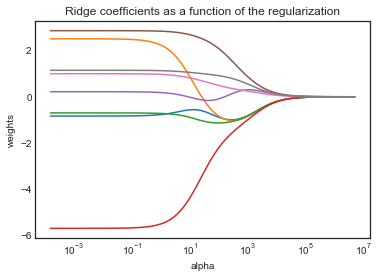

In [310]:
alphas3 = 5**np.linspace(10,-5,100)*0.5 

ridge3 = Ridge()
coefs3 = []

for a in alphas3:
    ridge3.set_params(alpha=a)
    ridge3.fit(scale(auto_X), auto_Y)
    coefs3.append(ridge3.coef_)

ax = plt.gca()
ax.plot(alphas3, coefs3)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

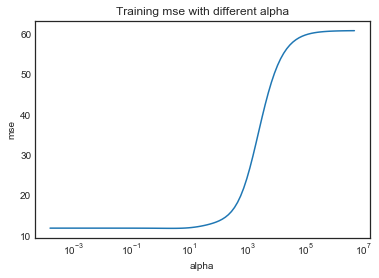

In [311]:
# Find optimal alpha coefficient using cross validation (refer to 3.4.4)
mse = []

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

for a in alphas3:
    ridge3 = Ridge(alpha=a)
    mse.append(-1*cross_val_score(ridge3, scale(auto_X_train), auto_y_train, cv=kf_10, scoring='neg_mean_squared_error').mean())

ax = plt.gca()
ax.plot(alphas3, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

In [312]:
# Verify the result using test data (refer to 3.4.5)
mse = []

for a in alphas3:
    ridge3 = Ridge(alpha=a)
    ridge3.fit(scaler.transform(auto_X_train), auto_y_train)
    pred = ridge3.predict(scaler.transform(auto_X_test))
    mse.append(mean_squared_error(auto_y_test, pred))

ax = plt.gca()
ax.plot(alphas3, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Test mse with different alpha')

Text(0.5, 1.0, 'Test mse with different alpha')

In [313]:
# Try RidgeCV (refer to 3.4.6)
ridgecv = RidgeCV(alphas=alphas3, scoring='neg_mean_squared_error')
ridgecv.fit(scale(auto_X_train), auto_y_train)
ridgecv.alpha_

2.1597191592564733

In [314]:
ridge3.set_params(alpha=ridgecv.alpha_)

Ridge(alpha=2.1597191592564733, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [315]:
ridge3.fit(scale(auto_X_train), auto_y_train)
mean_squared_error(auto_y_test, ridge3.predict(scale(auto_X_test)))

9.885949192270665

## 4. The Lasso

### 4.1. Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

In [316]:
# Lasso in Scikit-learn has a max iteration since it uses "Coordinate descent solver"
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

#### 4.1.1. Training mse with different alpha value

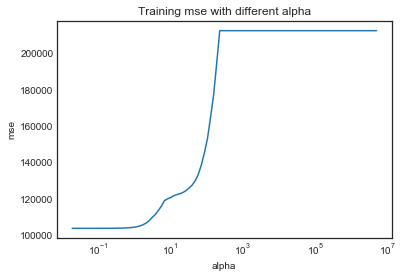

In [317]:
lasso = Lasso(max_iter=10000)
mse = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    
    mse.append(mean_squared_error(y_train, lasso.predict(scale(X_train))))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

#### 4.1.2. Training mse with different alpha value (Cross validataion)

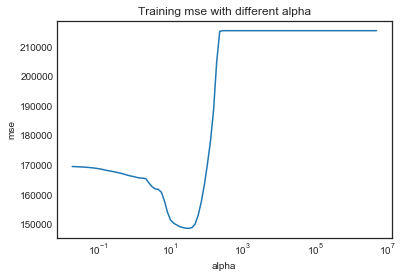

In [318]:
lasso = Lasso(max_iter=10000)
mse = []

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

for a in alphas:
    lasso.set_params(alpha=a)
    mse.append(-1*cross_val_score(lasso, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean())

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

####  4.1.3. Test mse with different alpha value

In [319]:
lasso = Lasso(max_iter=10000)
mse = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    
    mse.append(mean_squared_error(y_test, lasso.predict(scale(X_test))))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

####  4.1.4. Compute the regularization path using LassoCV
Lasso regression with built-in cross-validation.

Alphas are set automatically

In [320]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.as_matrix().ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [321]:
lassocv.alpha_

30.013822564464284

In [322]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102924.90954696965

In [323]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

### 4.2 Exercise 

Apply Lasso regression to Auto dataset ('Data/Auto.csv')
(Y : mpg)

1. Find optimal alpha coefficient using cross validation (refer to 4.1.2)
2. Verify the result using test data (refer to 4.1.3)
3. Try LassoCV (refer to 4.1.4)

In [339]:
lasso = Lasso(max_iter=10000)
mse = []

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

for a in alphas3:
    lasso.set_params(alpha=a)
    mse.append(-1*cross_val_score(lasso, scale(auto_X_train), auto_y_train, cv=kf_10, scoring='neg_mean_squared_error').mean())

ax = plt.gca()
ax.plot(alphas3, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

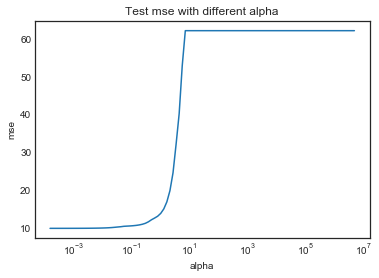

In [340]:
lasso = Lasso(max_iter=10000)
mse = []

for a in alphas3:
    lasso.set_params(alpha=a)
    lasso.fit(scale(auto_X_train), auto_y_train)
    
    mse.append(mean_squared_error(auto_y_test, lasso.predict(scale(auto_X_test))))

ax = plt.gca()
ax.plot(alphas3, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Test mse with different alpha');

In [341]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.as_matrix().ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [342]:
lassocv.alpha_

30.013822564464284

In [343]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102924.90954696965

## 5. Principal Components Regression

### 5.1 Scikit-learn
Scikit-learn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [325]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


0         1         2         3         4         5
0  0.198290 -0.383784  0.088626  0.031967  0.028117 -0.070646
1  0.195861 -0.377271  0.074032  0.017982 -0.004652 -0.082240
2  0.204369 -0.237136 -0.216186 -0.235831  0.077660 -0.149646
3  0.198337 -0.377721 -0.017166 -0.049942 -0.038536 -0.136660
4  0.235174 -0.314531 -0.073085 -0.138985  0.024299 -0.111675

The above loadings are the same as in R.

In [326]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


0         1         2         3         4         5
0 -0.009649  1.870522  1.265145 -0.935481  1.109636  1.211972
1  0.411434 -2.429422 -0.909193 -0.264212  1.232031  1.826617
2  3.466822  0.825947  0.555469 -1.616726 -0.857488 -1.028712
3 -2.558317 -0.230984  0.519642 -2.176251 -0.820301  1.491696
4  1.027702 -1.573537  1.331382  3.494004  0.983427  0.513675

The above principal components are the same as in R.

In [327]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

#### 5.1.1 Fitting PCA with training data

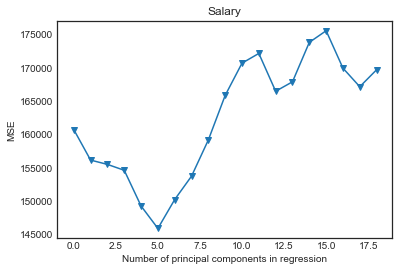

In [328]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### 5.1.2. Transform test data with PCA & compute test result

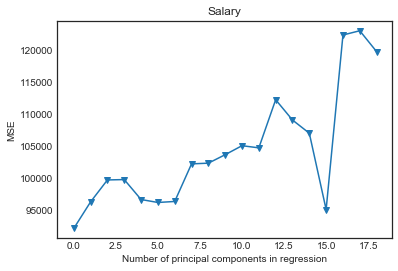

In [329]:
regr = LinearRegression()
mse = []

for i in np.arange(1, 20):
    X_reduced_test = pca2.transform(scale(X_test))[:,:i]

    # Train regression model on training data 
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:i], y_train)

    # Prediction with test data
    pred = regr.predict(X_reduced_test)
    mse.append(mean_squared_error(y_test, pred)) 


plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

### 5.2. Excercise
Use PCR to analyze Auto data 
(Follow steps from 5.1)


(313, 8)


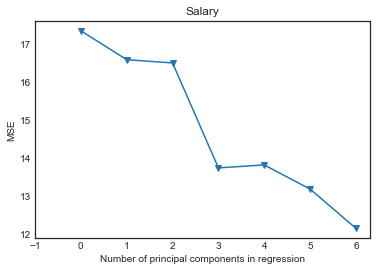

In [353]:
# Fit PCA with auto data
pca2 = PCA()
auto_X_reduced_train = pca2.fit_transform(scale(auto_X_train))
print(auto_X_reduced_train.shape)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 8):
    score = -1*cross_val_score(regr, auto_X_reduced_train[:,:i], auto_y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

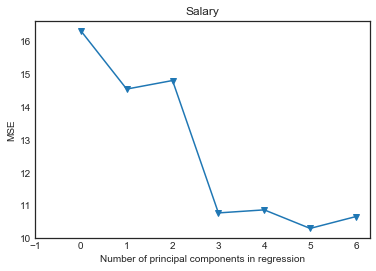

In [354]:
# Transform test data with PCA & compute test result
regr = LinearRegression()
mse = []

for i in np.arange(1, 8):
    X_reduced_test = pca2.transform(scale(auto_X_test))[:,:i]

    # Train regression model on training data 
    regr = LinearRegression()
    regr.fit(auto_X_reduced_train[:,:i], auto_y_train)

    # Prediction with test data
    pred = regr.predict(X_reduced_test)
    mse.append(mean_squared_error(auto_y_test, pred)) 


plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

## 6. Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'. 

When doing a slightly different fitting in R, the result is close to the one obtained using scikit-learn.

    pls.fit=plsr(Salary~., data=Hitters, subset=train, scale=TRUE, validation="CV", method='oscorespls')
    validationplot(pls.fit,val.type="MSEP", intercept = FALSE)
   
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

### 6.1. PLSRegression

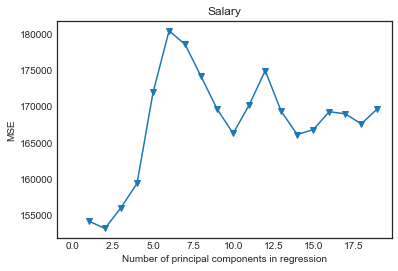

In [332]:
# Select best # of components using CV
n = len(X_train)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
    
    # without cross validation
    #pls.fit(scale(X_train), y_train)
    #pred = pls.predict(X_train)
    #mse.append(mean_squared_error(y_train, pred)) 

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

#### 6.1.1. Test mse with different # of principal components in regression

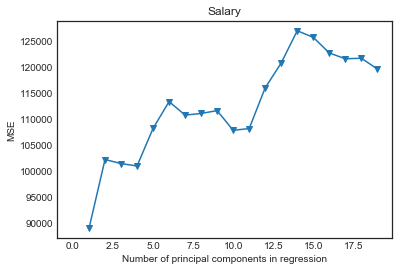

In [334]:

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    pls.fit(scale(X_train), y_train)

    mse.append(mean_squared_error(y_test, pls.predict(scale(X_test))))

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

### 6.2. Exercise
Use PLSRegression to analyze Auto data 
(Follow steps from 6.1)

In [355]:
# Select best # of components using CV
n = len(auto_X_train)

mse = []

for i in np.arange(1, 8):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(auto_X_train), auto_y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
    
    # without cross validation
    #pls.fit(scale(X_train), y_train)
    #pred = pls.predict(X_train)
    #mse.append(mean_squared_error(y_train, pred)) 

plt.plot(np.arange(1, 8), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [357]:
# Test mse with different # of principal components in regression

mse = []

for i in np.arange(1, 8):
    pls = PLSRegression(n_components=i)
    pls.fit(scale(auto_X_train), auto_y_train)

    mse.append(mean_squared_error(auto_y_test, pls.predict(scale(auto_X_test))))

plt.plot(np.arange(1, 8), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);